<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 45


Chromosome 5

* [R1 1000000-20000000](#r1)
* [R2 20000000-40000000](#r2) 
* [R3 60000000-80000000](#r3)
* [R4 80000000-100000000](#r4)
* [R5 100000000-120000000](#r5)
* [R6 120000000-140000000](#r6)
* [R7 140000000-160000000](#r7)
* [R8 160000000-180000000](#r8)


In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
from pomegranate import *
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from helpers import read_configuration_file, INFO, WARNING
from train import load_regions
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [4]:
from notebooks_helpers import filter_viterbi_path
from notebooks_helpers import save_segments
from notebooks_helpers import load_data_file
from notebooks_helpers import get_start_end_segment
from notebooks_helpers import make_data_array
from notebooks_helpers import gmm_clustering
from notebooks_helpers import create_viterbi_path
from notebooks_helpers import create_states
from notebooks_helpers import create_tuf_state
from notebooks_helpers import get_states_counter
from notebooks_helpers import plot_hmm_states_to_labels
from notebooks_helpers import plot_hmm_label_state
from notebooks_helpers import plot_hmm_cluster_contours

In [5]:
sns.set(color_codes=True)

Apply ```HMM_Model_9.json``` in regions:  

- ```region_0_REGION_1_CHR_5_MEAN_CUTOFF.txt```  [1000000-20000000]
- ```region_0_REGION_2_CHR_5_MEAN_CUTOFF.txt```  [20000000-40000000]
- ```region_0_REGION_3_CHR_5_MEAN_CUTOFF.txt```  [60000000-80000000]
- ```region_0_REGION_4_CHR_5_MEAN_CUTOFF.txt```  [80000000-100000000]
- ```region_0_REGION_5_CHR_5_MEAN_CUTOFF.txt``` [100000000-120000000]
- ```region_0_REGION_6_CHR_5_MEAN_CUTOFF.txt``` [120000000-140000000]
- ```region_0_REGION_7_CHR_5_MEAN_CUTOFF.txt``` [140000000-160000000]
- ```region_0_REGION_8_CHR_5_MEAN_CUTOFF.txt``` [160000000-180000000]

Orphan state HMM_Model-start removed due to no edges                             leading to it
Orphan state HMM_Model-end removed due to no edges                             leading to it


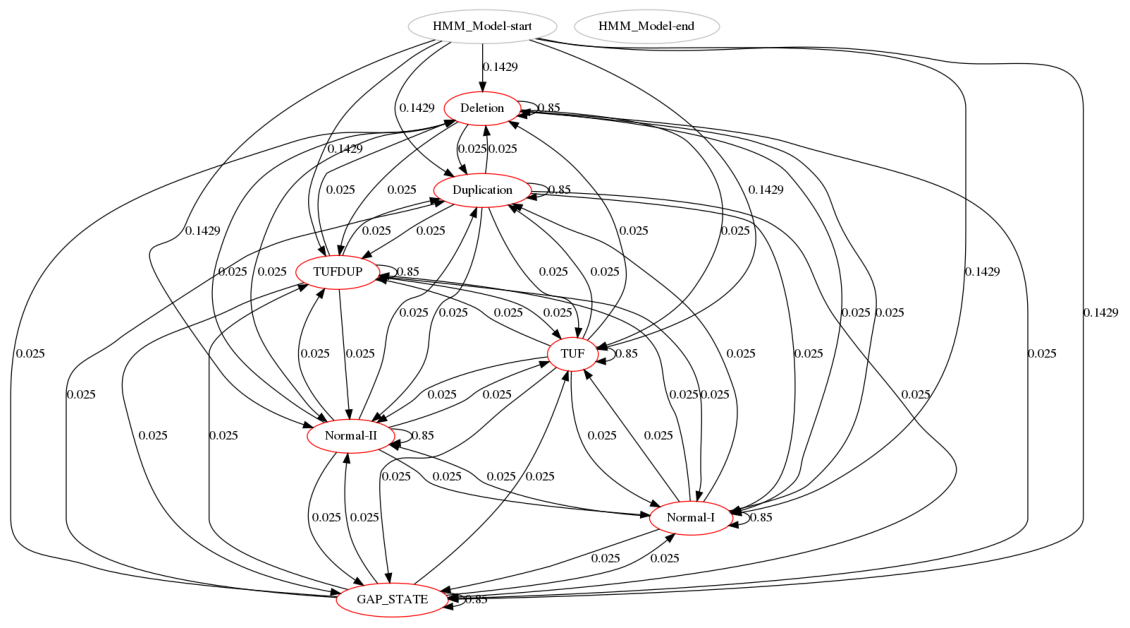

In [6]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]
hmm_filename = "HMM_Model_9.json"
hmm_model = build_hmm(hmm_file=hmm_filename)
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm_model.plot()
plt.show()

## <a name="r1"></a>  Region 1

In [7]:
# load the region we want to use for prediction
region_name = "region_0_REGION_1_CHR_5_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_1_CHR_5_MEAN_CUTOFF.txt
Sequence length:  189852


In [8]:
filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model,
                                                                         chr='chr5',
                                                                         filename=filename)

Observation length:  189852
Done. Execution time 0.8736358420001125 secs
Log-probability of ML Viterbi path:  -1262242.382172149
Viterbi path length:  189853
There should be 501 gaps


In [9]:
# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr5', filename=filename)

Length of path  189852
Length of TUF+DELETION+TUF state:  2115


In [10]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  189351
Encountered gaps:  501


In [11]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

{'Duplication': 199, 'Normal-I': 143823, 'Normal-II': 40090, 'Deletion': 194, 'Single-Deletion': 0, 'TUF': 5038, 'GAP_STATE': 501, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 7}


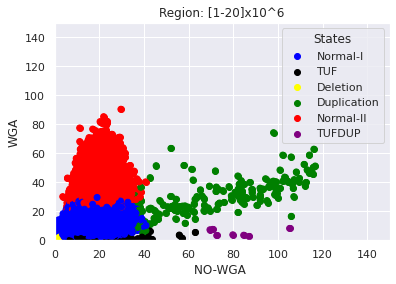

HMM labels color:  {'blue': [1, 143823], 'black': [5, 5038], 'yellow': [3, 194], 'green': [0, 199], 'red': [2, 40090], 'purple': [6, 7]}


In [12]:
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [1-20]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

In [13]:
for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

State:  Duplication
WGA mean/var:  28.80994974874372 141.36738240953514
NO-WGA mean/var:  65.2199497487437 745.015125123103
State:  Normal-I
WGA mean/var:  15.788562886325549 25.966919897811717
NO-WGA mean/var:  18.61358621360979 21.597203175449987
State:  Normal-II
WGA mean/var:  30.957756547767524 56.435402739433925
NO-WGA mean/var:  19.572342229982542 18.96212242116749
State:  Deletion
WGA mean/var:  0.8761340206185568 1.3206587655436282
NO-WGA mean/var:  2.111494845360825 2.0092652912105433
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.4119094878920206 2.586214615070758
NO-WGA mean/var:  14.56643112346169 24.199206794680396
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP
WGA mean/var:  5.192857142857144 4.763906122448979
NO-WGA mean/var:  81.38571428571427 135.12505306122446


In [14]:
#plot_hmm_label_state(hmm_states_to_labels=hmm_states_to_labels, hmm_labels=hmm_labels, 
#                     no_wga_obs=no_wga_obs, wga_obs=wga_obs, nbins=80, xlim=(0.0, 140.),ylim=(0.0, 140.))

State:  Deletion
[[0.970271600267186, 0.958137372653406], [[1.1036072543648185, 0.0], [0.0, 1.1932036611641303]]]
State:  Duplication
[[24.283621138294365, 55.0], [[39.473393085057296, 0.0], [0.0, 71.53462337717849]]]
State:  Normal-I
[[13.750290519035646, 16.65535114027298], [[19.019257854346822, 0.0], [0.0, 31.488140792022595]]]
State:  Normal-II
[[40.0, 19.641842481040367], [[52.49115328954019, 0.0], [0.0, 19.606180750829882]]]
State:  TUF
[[1.7345118994138116, 14.220278071386755], [[1.9260086547849433, 0.0], [0.0, 15.655595281606255]]]
[[1.7345118994138116, 40.0], [[1.9260086547849433, 0.0], [0.0, 28.60670595671783]]]
Weights found:  [-0.69314718 -0.69314718]
Weights:  [0.5 0.5]
State:  TUFDUP
[[1.7345118994138116, 85.0], [[1.9260086547849433, 0.0], [0.0, 93.36225933227568]]]
state:  TUF
state:  Deletion
state:  Duplication
state:  Normal-I
state:  Normal-II
state:  TUFDUP


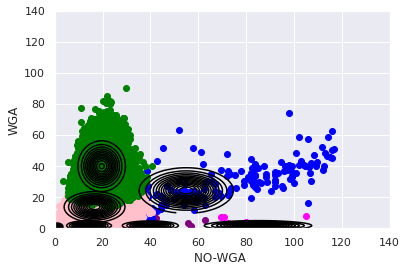

In [15]:
obs_state = {}

for state in hmm_states_to_labels:
    obs_state[state] = []

for i, obs in enumerate(observations):
        if obs != (-999.0, -999.0):
            viterbi_state = sequence_viterbi_state[i][1]
            obs_state[viterbi_state].append(obs)
            
states = hmm_model.states

state_vars = {}

for state in states:
    
    if state.name in hmm_states_to_labels:
        
        print("State: ", state.name)
        
        if state.distribution.name == "MultivariateGaussianDistribution":
            print(state.distribution.parameters)
            
            state_vars[state.name] = state.distribution.parameters
            
        elif state.name == 'TUF':
            
            state_vars[state.name] = {}
           
            for i, comp in enumerate(state.distribution.distributions):
                state_vars[state.name]["comp"+str(i)] = comp.parameters
                print(comp.parameters)
            weights = state.distribution.weights
            print("Weights found: ", weights)
            state_vars[state.name]["weights"] = np.exp(weights) 
            print("Weights: ", state_vars[state.name]["weights"])


state_colors={'TUF':"purple", "Deletion":"red",
                'Duplication':"blue", "Normal-I":"pink",
                "Normal-II":"green",
             'TUFDUP':'magenta'}

state_min_max = {'TUF':{'min_x': 0.0, 'max_x':140.0, 'min_y': 0.0, 'max_y':10.0},
                 'TUFDUP':{'min_x': 40.0, 'max_x':140.0, 'min_y': 0.0, 'max_y':10.0},
                 'Deletion':{'min_x': 0.0, 'max_x':10.0, 'min_y': 0.0, 'max_y':10.0},
                 'Normal-II':{'min_x': 0.0, 'max_x':45.0, 'min_y': 0.0, 'max_y':140.0},
                 'Normal-I':{'min_x': 0.0, 'max_x':45.0, 'min_y': 0.0, 'max_y':35.0},
                 'Duplication':{'min_x': 20.0, 'max_x':140.0, 'min_y': 10.0, 'max_y':140.0}}

plot_hmm_cluster_contours(state_colors=state_colors, state_vars=state_vars, 
                          obs_state=obs_state, nbins=80, ncontours=14, state_min_max=state_min_max)

## <a name="r2"></a> Region 2

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_2_CHR_5_MEAN_CUTOFF.txt
Sequence length:  199982
Observation length:  199982
Done. Execution time 0.9451287840001896 secs
Log-probability of ML Viterbi path:  -1347350.7554393723
Viterbi path length:  199983
There should be 0 gaps
Length of path  199982
Length of TUF+DELETION+TUF state:  206
Length of WGA Observations:  199982
Encountered gaps:  0
{'Duplication': 520, 'Normal-I': 164594, 'Normal-II': 34277, 'Deletion': 80, 'Single-Deletion': 0, 'TUF': 511, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


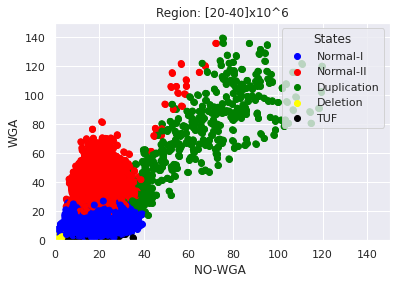

HMM labels color:  {'blue': [1, 164594], 'red': [2, 34277], 'green': [0, 520], 'yellow': [3, 80], 'black': [5, 511]}
State:  Duplication
WGA mean/var:  58.866846153846154 1010.5990958224852
NO-WGA mean/var:  55.287134615384616 515.2815235203403
State:  Normal-I
WGA mean/var:  15.927255428508936 23.171872159175148
NO-WGA mean/var:  19.64126104232232 21.39672817513431
State:  Normal-II
WGA mean/var:  30.061944744289175 46.354236834126255
NO-WGA mean/var:  20.28061761531056 19.492021898797557
State:  Deletion
WGA mean/var:  0.9576249999999998 1.291803109375
NO-WGA mean/var:  1.373 1.8017609999999997
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.8532093933463796 2.2459004630037414
NO-WGA mean/var:  15.91017612524462 30.01827374588792
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [16]:
# load the region we want to use for prediction
region_name = "region_0_REGION_2_CHR_5_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr5',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr5', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [20-40]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r3"></a>  Region 3

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_3_CHR_5_MEAN_CUTOFF.txt
Sequence length:  199994
Observation length:  199994
Done. Execution time 0.9805474999998296 secs
Log-probability of ML Viterbi path:  -1364363.8768879112
Viterbi path length:  199995
There should be 0 gaps
Length of path  199994
Length of TUF+DELETION+TUF state:  77
Length of WGA Observations:  199994
Encountered gaps:  0
{'Duplication': 713, 'Normal-I': 148657, 'Normal-II': 49828, 'Deletion': 218, 'Single-Deletion': 0, 'TUF': 578, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


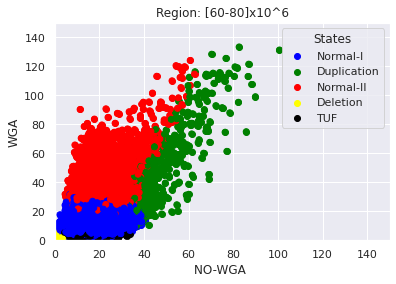

HMM labels color:  {'blue': [1, 148657], 'green': [0, 713], 'red': [2, 49828], 'yellow': [3, 218], 'black': [5, 578]}
State:  Duplication
WGA mean/var:  41.17244039270687 601.4459227962366
NO-WGA mean/var:  42.90297335203366 148.74477236534878
State:  Normal-I
WGA mean/var:  16.27439044242787 24.886337606637696
NO-WGA mean/var:  18.60808525666467 22.664741080389465
State:  Normal-II
WGA mean/var:  31.04339226940676 59.26347506431528
NO-WGA mean/var:  20.10536023922293 21.37076131559978
State:  Deletion
WGA mean/var:  1.7191743119266054 1.47475252924838
NO-WGA mean/var:  2.0759633027522937 1.5989314114973485
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.148875432525952 1.788088873756301
NO-WGA mean/var:  13.329896193771626 39.5367255947606
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [17]:
# load the region we want to use for prediction
region_name = "region_0_REGION_3_CHR_5_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr5',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr5', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [60-80]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r4"></a>  Region 4

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_4_CHR_5_MEAN_CUTOFF.txt
Sequence length:  200000
Observation length:  200000
Done. Execution time 0.9962365970000064 secs
Log-probability of ML Viterbi path:  -1343786.2143339103
Viterbi path length:  200001
There should be 0 gaps
Length of path  200000
Length of TUF+DELETION+TUF state:  51
Length of WGA Observations:  200000
Encountered gaps:  0
{'Duplication': 112, 'Normal-I': 161775, 'Normal-II': 37758, 'Deletion': 154, 'Single-Deletion': 0, 'TUF': 201, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


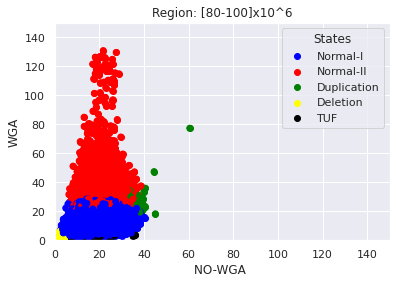

HMM labels color:  {'blue': [1, 161775], 'red': [2, 37758], 'green': [0, 112], 'yellow': [3, 154], 'black': [5, 201]}
State:  Duplication
WGA mean/var:  25.50964285714286 41.00595880102039
NO-WGA mean/var:  33.910267857142856 19.643454392538267
State:  Normal-I
WGA mean/var:  16.28359592025962 22.80482653590052
NO-WGA mean/var:  19.71491398547365 20.645085100776438
State:  Normal-II
WGA mean/var:  29.77231633031411 50.53898883981542
NO-WGA mean/var:  20.537125642248 18.01889296959461
State:  Deletion
WGA mean/var:  0.5418831168831169 1.2987516486759993
NO-WGA mean/var:  0.5836363636363637 1.3475698937426208
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.3161691542288554 1.406405722630628
NO-WGA mean/var:  12.918407960199007 38.87851288829485
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [18]:
# load the region we want to use for prediction
region_name = "region_0_REGION_4_CHR_5_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr5',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr5', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [80-100]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r5"></a>  Region 5

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_5_CHR_5_MEAN_CUTOFF.txt
Sequence length:  200000
Observation length:  200000
Done. Execution time 1.169947269000204 secs
Log-probability of ML Viterbi path:  -1348648.8972559
Viterbi path length:  200001
There should be 0 gaps
Length of path  200000
Length of TUF+DELETION+TUF state:  88
Length of WGA Observations:  200000
Encountered gaps:  0
{'Duplication': 106, 'Normal-I': 158551, 'Normal-II': 40975, 'Deletion': 38, 'Single-Deletion': 0, 'TUF': 330, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


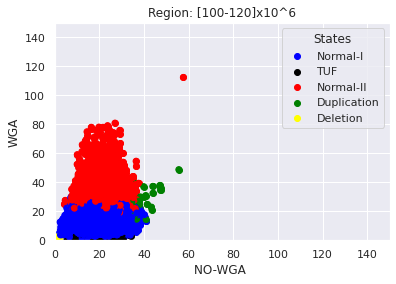

HMM labels color:  {'blue': [1, 158551], 'black': [5, 330], 'red': [2, 40975], 'green': [0, 106], 'yellow': [3, 38]}
State:  Duplication
WGA mean/var:  25.525094339622648 25.51484008543966
NO-WGA mean/var:  34.67283018867925 21.53889953720185
State:  Normal-I
WGA mean/var:  16.52820127277658 22.591027745778856
NO-WGA mean/var:  19.70122522090684 20.58138204608351
State:  Normal-II
WGA mean/var:  29.46017400854179 36.52600617594433
NO-WGA mean/var:  20.49751995118975 17.8578265717496
State:  Deletion
WGA mean/var:  1.615 1.738688157894737
NO-WGA mean/var:  1.7542105263157894 1.6520191135734075
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.9957272727272724 1.9224371983471074
NO-WGA mean/var:  16.54978787878788 32.725826318640955
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [19]:
# load the region we want to use for prediction
region_name = "region_0_REGION_5_CHR_5_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr5',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr5', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [100-120]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r6"></a>  Region 6 

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_6_CHR_5_MEAN_CUTOFF.txt
Sequence length:  200000
Observation length:  200000
Done. Execution time 0.7927121930001704 secs
Log-probability of ML Viterbi path:  -1350741.3975689465
Viterbi path length:  200001
There should be 11 gaps
Length of path  200000
Length of TUF+DELETION+TUF state:  89
Length of WGA Observations:  199989
Encountered gaps:  11
{'Duplication': 80, 'Normal-I': 146860, 'Normal-II': 51686, 'Deletion': 144, 'Single-Deletion': 0, 'TUF': 1219, 'GAP_STATE': 11, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


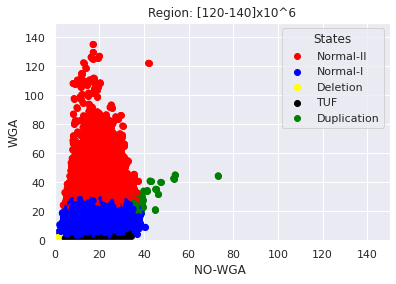

HMM labels color:  {'red': [2, 51686], 'blue': [1, 146860], 'yellow': [3, 144], 'black': [5, 1219], 'green': [0, 80]}
State:  Duplication
WGA mean/var:  27.0605 33.184292250000006
NO-WGA mean/var:  35.931875 44.220797734375004
State:  Normal-I
WGA mean/var:  16.47068861500749 24.03568822593194
NO-WGA mean/var:  18.640873689227835 21.355221854806857
State:  Normal-II
WGA mean/var:  31.47773013968967 69.6471148918467
NO-WGA mean/var:  19.53129957822234 19.79655291195548
State:  Deletion
WGA mean/var:  0.5009027777777777 1.0991207127700617
NO-WGA mean/var:  0.6118750000000001 1.4464457899305556
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.0704183757178014 1.906741826602448
NO-WGA mean/var:  15.892141099261691 27.796510017826847
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [20]:
# load the region we want to use for prediction
region_name = "region_0_REGION_6_CHR_5_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr5',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr5', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [120-140]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r7"></a>  Region 7

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_7_CHR_5_MEAN_CUTOFF.txt
Sequence length:  200000
Observation length:  200000
Done. Execution time 1.1213262480000594 secs
Log-probability of ML Viterbi path:  -1370994.173619267
Viterbi path length:  200001
There should be 11 gaps
Length of path  200000
Length of TUF+DELETION+TUF state:  113
Length of WGA Observations:  199989
Encountered gaps:  11
{'Duplication': 107, 'Normal-I': 134086, 'Normal-II': 65340, 'Deletion': 28, 'Single-Deletion': 0, 'TUF': 428, 'GAP_STATE': 11, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


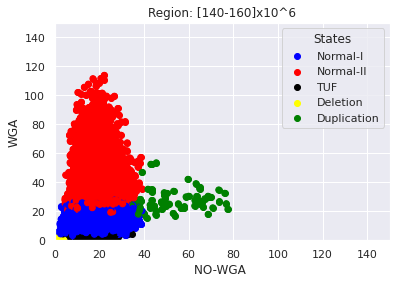

HMM labels color:  {'blue': [1, 134086], 'red': [2, 65340], 'black': [5, 428], 'yellow': [3, 28], 'green': [0, 107]}
State:  Duplication
WGA mean/var:  26.90345794392523 47.86277776224998
NO-WGA mean/var:  45.8241121495327 184.0254036509739
State:  Normal-I
WGA mean/var:  17.0651067225512 23.649140055060187
NO-WGA mean/var:  18.337736154408365 20.46376112427599
State:  Normal-II
WGA mean/var:  32.194649066421796 80.08939231792306
NO-WGA mean/var:  19.0491955922865 18.584744378945985
State:  Deletion
WGA mean/var:  0.9214285714285715 1.0180051020408165
NO-WGA mean/var:  1.7521428571428572 1.5660382653061224
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.2322429906542056 1.7203720717966637
NO-WGA mean/var:  14.672733644859811 26.67679462998952
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [21]:
# load the region we want to use for prediction
region_name = "region_0_REGION_7_CHR_5_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr5',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr5', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [140-160]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r8"></a>  Region 8

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_8_CHR_5_MEAN_CUTOFF.txt
Sequence length:  199997
Observation length:  199997
Done. Execution time 1.1196617979999246 secs
Log-probability of ML Viterbi path:  -1356378.9583431438
Viterbi path length:  199998
There should be 0 gaps
Length of path  199997
Length of TUF+DELETION+TUF state:  993
Length of WGA Observations:  199997
Encountered gaps:  0
{'Duplication': 204, 'Normal-I': 144235, 'Normal-II': 52562, 'Deletion': 339, 'Single-Deletion': 0, 'TUF': 2657, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


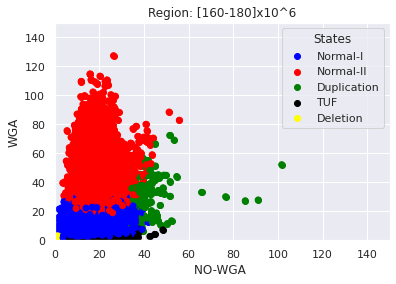

HMM labels color:  {'blue': [1, 144235], 'red': [2, 52562], 'green': [0, 204], 'black': [5, 2657], 'yellow': [3, 339]}
State:  Duplication
WGA mean/var:  29.008382352941176 119.72131159890426
NO-WGA mean/var:  38.81254901960784 87.25618075740101
State:  Normal-I
WGA mean/var:  16.149733698478176 25.94041319424106
NO-WGA mean/var:  18.004789614171315 22.28463994932466
State:  Normal-II
WGA mean/var:  32.08970644191621 86.31110904779875
NO-WGA mean/var:  18.79848978349378 20.226534981907342
State:  Deletion
WGA mean/var:  1.1428908554572272 1.6183810234856986
NO-WGA mean/var:  1.8434808259587023 2.063912367626456
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.7704140007527287 2.436558579073832
NO-WGA mean/var:  14.961147911178022 30.448769890429396
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [22]:
# load the region we want to use for prediction
region_name = "region_0_REGION_8_CHR_5_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr5',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr5/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr5', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [160-180]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))